# Testing calibrate_ingested.py

This notebook will aim to test the `calibrate_ingested.py` script alongside the `load_afterpulse.py` script.

We will take the following steps:

1. Load in a day of .mpl.gz files and convert from the raw to ingested format.
2. Load in an afterpulse file for a recent date.
3. Generate the overlap function from David Turner.
4. Generate the calibrated data from the ingested data
5. Plot it and see how badly it went...

In [1]:
# initial imports, etc

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

import os

import load_mpl_inline
import raw_to_ingested
import load_afterpulse
import calibrate_ingested

In [2]:
dir_mpl = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/raw'

d = datetime.date(2019,7,5)
fname_mpl = f'{d.year:04}{d.month:02}{d.day:02}*.mpl.gz'

fname_afterpulse = '202105151437.mpl.gz' #202205251346.mpl.gz

## 1. Load data

Loading the raw .mpl.gz data for a given day and ingesting the format.

In [3]:
ds = load_mpl_inline.mf_load_mpl_inline(fname_mpl,dir_mpl)
ds = raw_to_ingested.raw_to_ingested(None,None, data_loaded=ds)
ds

loading 201907050000.mpl.gz
loading 201907050100.mpl.gz
loading 201907050200.mpl.gz
loading 201907050300.mpl.gz
loading 201907050400.mpl.gz
loading 201907050500.mpl.gz
loading 201907050600.mpl.gz
loading 201907050700.mpl.gz
loading 201907050800.mpl.gz
loading 201907050900.mpl.gz
loading 201907051000.mpl.gz
loading 201907051100.mpl.gz
loading 201907051200.mpl.gz
loading 201907051300.mpl.gz
loading 201907051400.mpl.gz
loading 201907051500.mpl.gz
loading 201907051600.mpl.gz
loading 201907051700.mpl.gz
loading 201907051800.mpl.gz
loading 201907051900.mpl.gz
loading 201907052000.mpl.gz
loading 201907052100.mpl.gz
loading 201907052200.mpl.gz
loading 201907052300.mpl.gz


<xarray.Dataset>
Dimensions:          (time: 17280, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-07-05T00:00:01 ... 2019-07-05...
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/19)
    base_time        datetime64[ns] 2019-07-05T00:00:01
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:54
    hour             (time) float32 0.0002778 0.001667 0.003056 ... 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.26 5.26 5.261 5.261 ... 5.303 5.304 5.303
    ...               ...
    initial_cbh      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    backscatter_1    (time, height) float32 0.0912 0.112 ... 0.0912 0.1056
    backscatter_2    (time, height) float32 0.1072 0.1056 ... 0.112 0.0912
    lat              float32 72.6
    lon              float32 -38.42
    alt              float32 3.2e+03
Attributes:
    Date_created:              2023-02-17T14:28:13 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

## 2. Load afterpulse data

In [4]:
afterpulse = load_afterpulse.load_afterpulse(os.path.join(dir_mpl,fname_afterpulse))
afterpulse

<xarray.Dataset>
Dimensions:    (height: 1200)
Coordinates:
  * height     (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables:
    channel_1  (height) float32 0.0002163 0.0002 ... 0.0002832 0.0002003
    channel_2  (height) float32 0.0001503 0.0003831 ... 0.0002503 0.0003838
    E0         float32 4.448

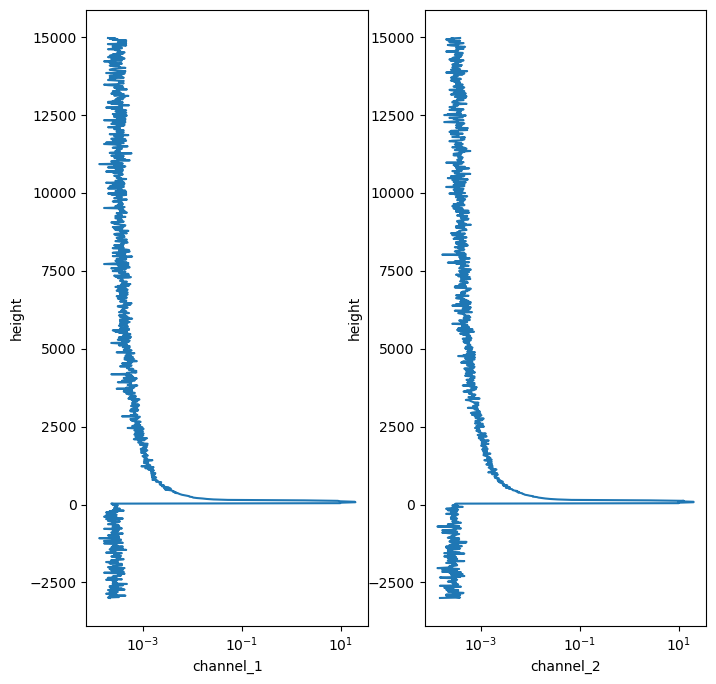

In [5]:
fig,axs = plt.subplots(1,2,figsize=(8,8))

afterpulse.channel_1.plot(y='height',xscale='log',ax=axs[0])
afterpulse.channel_2.plot(y='height',xscale='log',ax=axs[1])

## 3. Generate overlap function

In [6]:
# taken from David Turner
# heights need to be converted from km to m
ocorr = np.array([0.00530759, 0.0583835, 0.110524, 0.174668, 0.246036, 0.333440, 0.421466,0.510560, 0.599191, 0.676644, 0.744512, 0.808004, 0.848976,0.890453, 0.959738, 0.975302, 1.0, 1.0])

oht = np.array([0.0149896, 0.164886, 0.314782, 0.464678, 0.614575, 0.764471, 0.914367,1.06426, 1.21416, 1.36406, 1.51395, 1.66385, 1.81374, 1.96364,2.11354, 2.26343, 2.5, 20]) * 1e3

overlap = np.vstack((oht, ocorr))

## 4. Generate the calibrated data

In [7]:
sources = {'afterpulse': fname_afterpulse, 'overlap': 'David Turner'}

ds_cal = calibrate_ingested.calibrate_ingested(ds, overlap=overlap, afterpulse=afterpulse, sources=sources)

ds_cal

<xarray.Dataset>
Dimensions:          (time: 17280, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-07-05T00:00:01 ... 2019-07-05...
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/28)
    base_time        datetime64[ns] 2019-07-05T00:00:01
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:54
    hour             (time) float32 0.0002778 0.001667 0.003056 ... 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.26 5.26 5.261 5.261 ... 5.303 5.304 5.303
    ...               ...
    NRB_1            (time, height) float64 0.0 6.432e-10 ... 0.0 5.848e-11
    A_det            float64 0.03243
    dz               float64 14.99
    E_photon         float64 3.734e-19
    afterpulse_2     (height) float64 0.0001503 0.0003831 ... 0.0003838
    NRB_2            (time, height) float64 2.86e-10 9.926e-11 ... 1.414e-10 0.0
Attributes:
    Date_created:              2023-02-17T14:28:13 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

## 5. Lots of plots!

### afterpulse and overlap
Just to ensure they're behaving as expected when interpolated...

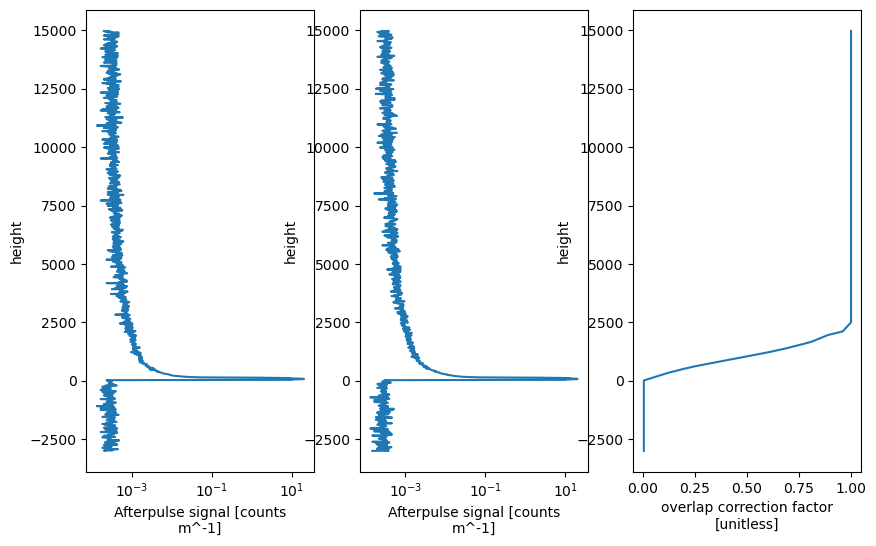

In [8]:
fig,axs = plt.subplots(1,3,figsize=(10,6))

ds_cal.afterpulse_1.plot(y='height',xscale='log',ax=axs[0])
ds_cal.afterpulse_2.plot(y='height',xscale='log',ax=axs[1])
ds_cal.overlap.plot(y='height',ax=axs[2])

### NRB vs backscatter
I'll plot NRB vs backscatter in both channels so that comparissons can be made, as well as their depolarisation ratios.

/home/users/eeasm/.conda/envs/icesat_summit/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


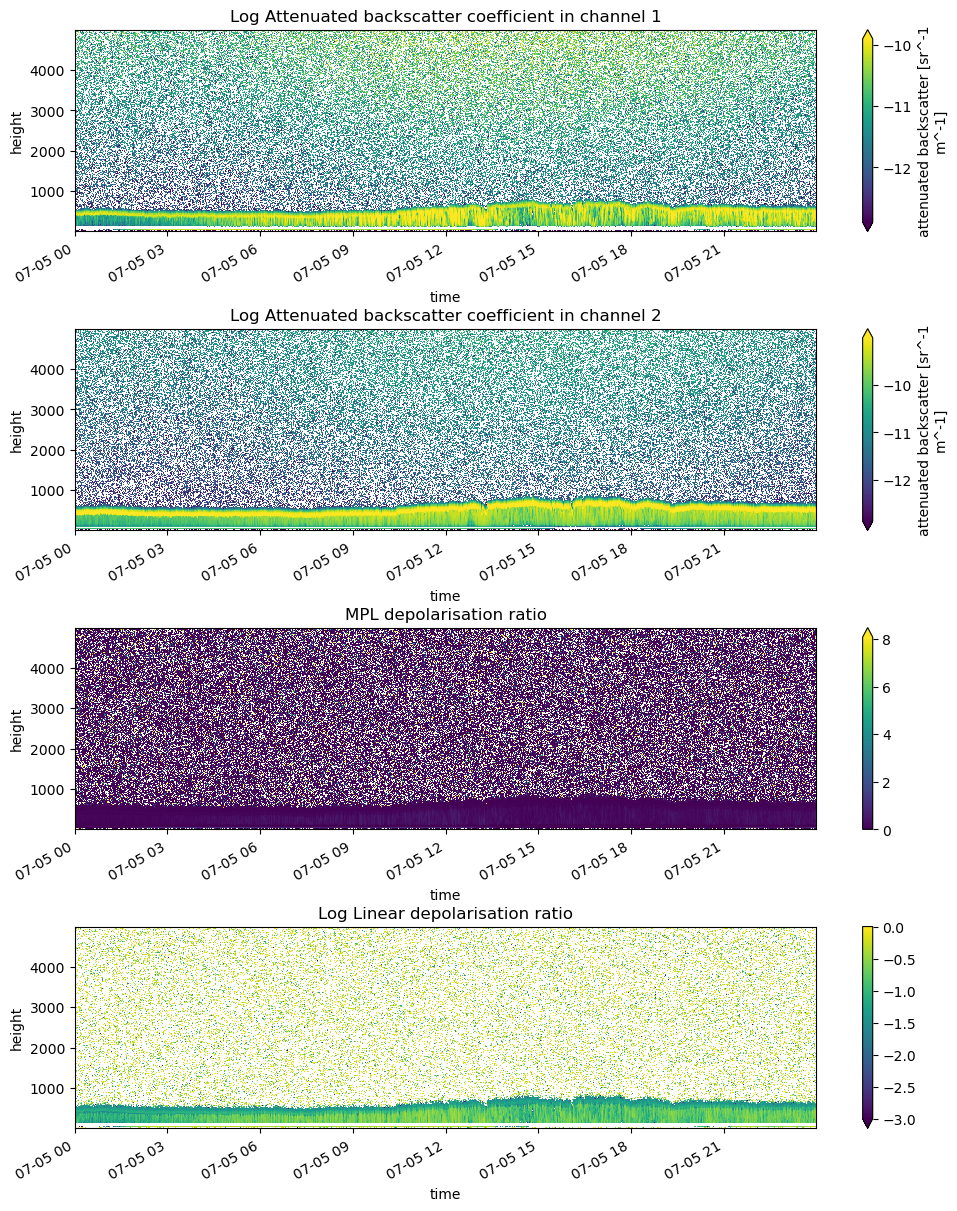

In [9]:
fig, axs = plt.subplots(4,1,figsize=(10,12))


NRB_1 = ds_cal.NRB_1.where(ds_cal['height'] > 0, drop=True).where(ds_cal.height < 5000,drop=True)
NRB_2 = ds_cal.NRB_2.where(ds_cal.height > 0, drop=True).where(ds_cal.height < 5000, drop=True)





np.log10(NRB_1).plot(x='time',robust=True,ax=axs[0])
np.log10(NRB_2).plot(x='time',robust=True,ax=axs[1])

dpol_mpl = NRB_1 / NRB_2
dpol_mpl = dpol_mpl.fillna(0)


dpol_linear = dpol_mpl / (1+ dpol_mpl)

dpol_mpl.plot(x='time',robust=True, ax=axs[2])
np.log10(dpol_linear).plot(x='time', ax=axs[3], vmax=0, vmin=-3)

axs[0].set_title('Log Attenuated backscatter coefficient in channel 1')
axs[1].set_title('Log Attenuated backscatter coefficient in channel 2')
axs[2].set_title('MPL depolarisation ratio')
axs[3].set_title('Log Linear depolarisation ratio')


fig.tight_layout(pad=0.3)

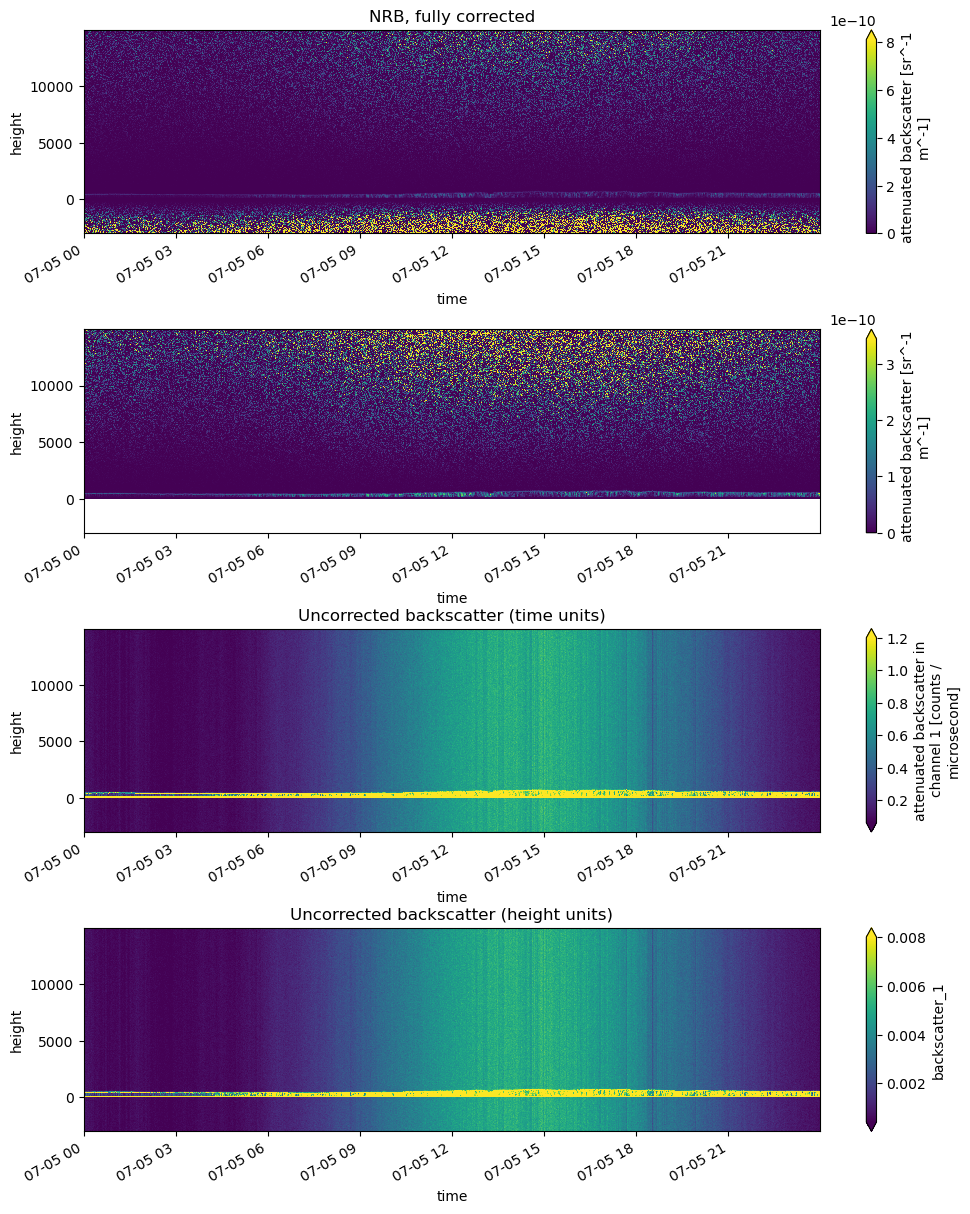

In [21]:
fig, axs = plt.subplots(4,1,figsize=(10,12))

ds_cal.NRB_1.plot(x='time',robust=True,ax=axs[0])
axs[0].set_title('NRB, fully corrected')

NRB_1 = ds_cal.NRB_1.where(ds_cal.NRB_1 > 0,0).where(ds_cal.height>0)
NRB_1.plot(x='time',robust=True,ax=axs[1])

ds_cal.backscatter_1.plot(x='time',robust=True,ax=axs[2])
axs[2].set_title('Uncorrected backscatter (time units)')

(ds_cal.backscatter_1 * 2 / 299792458 * 1e6).plot(x='time',robust=True,ax=axs[3])
axs[3].set_title('Uncorrected backscatter (height units)')

fig.tight_layout(pad=0.2)

AttributeError: 'Dataset' object has no attribute 'NRB_1_background'

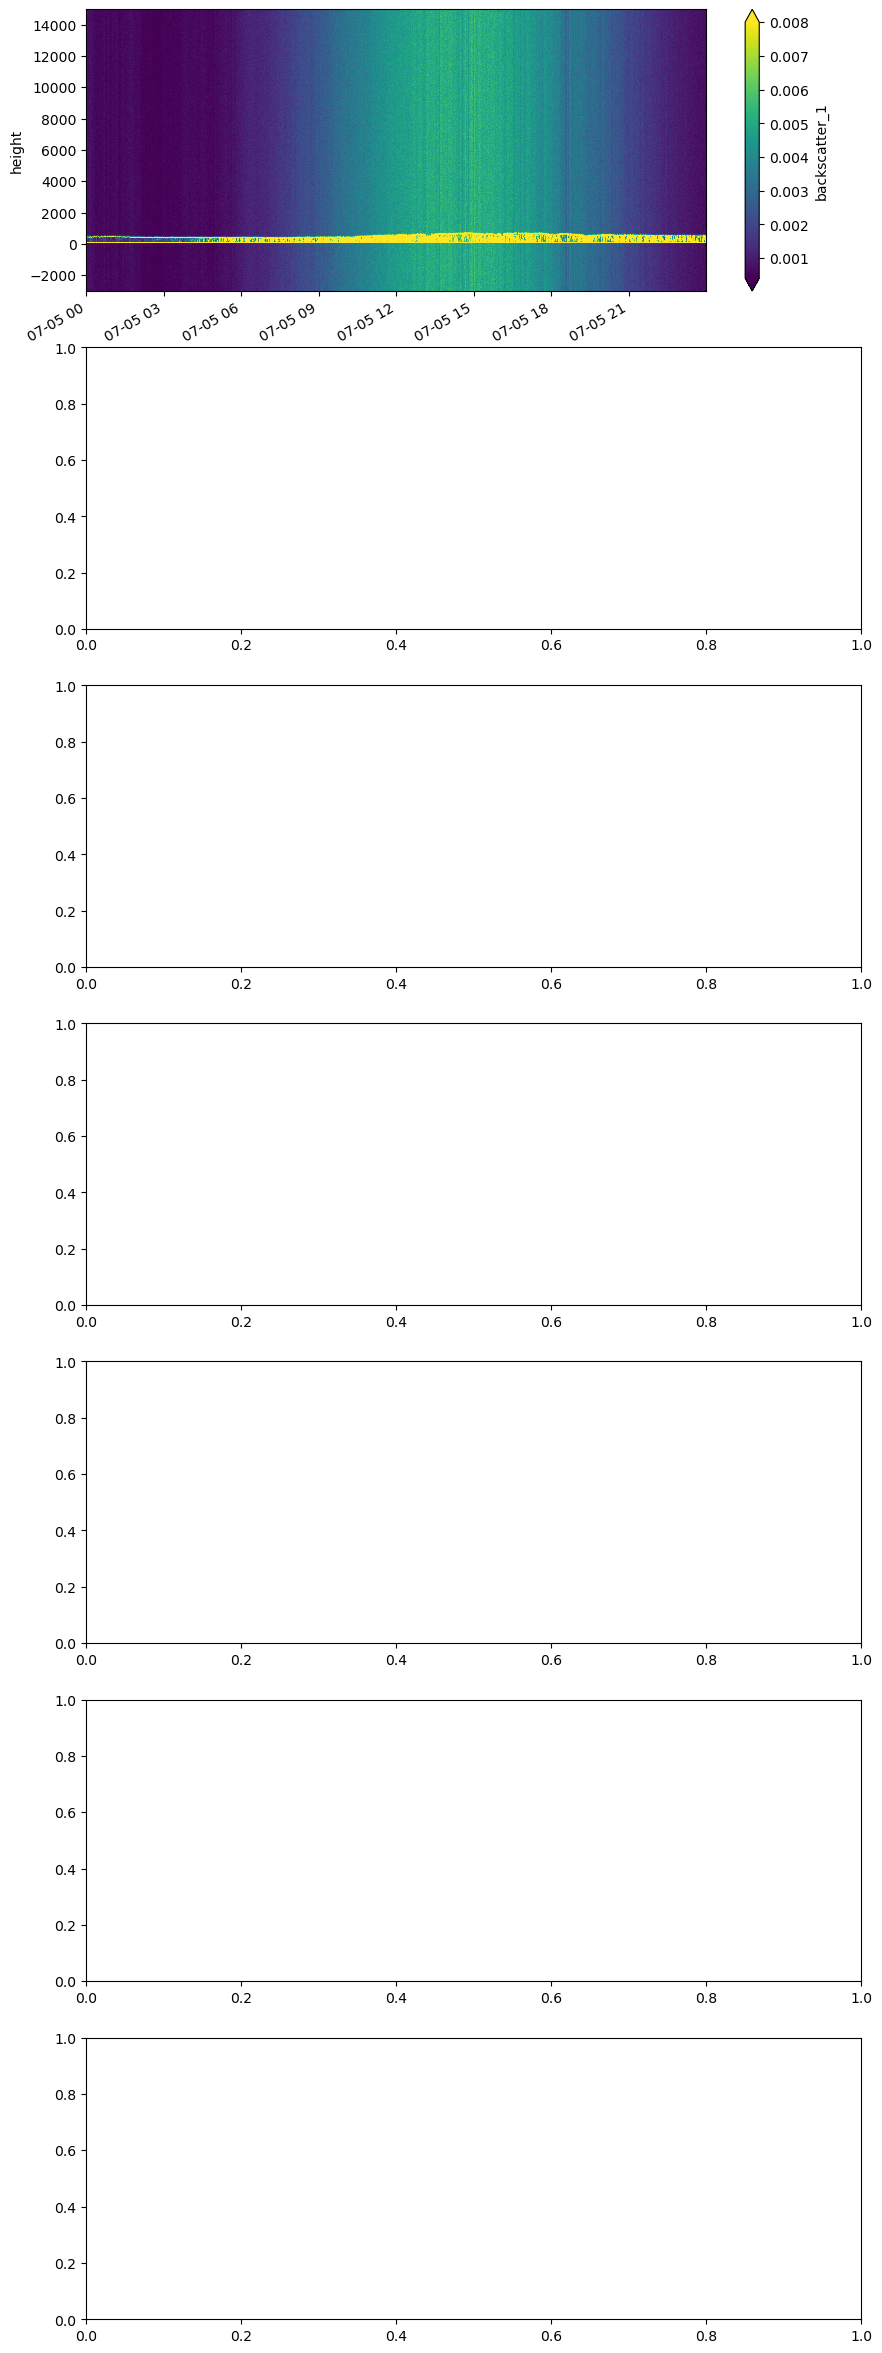

In [22]:
fig, axs = plt.subplots(7,1,figsize=(10,30))

# raw (scaled for height units)
a = (ds_cal.backscatter_1 * 2 / 299792458 * 1e6)
a.plot(x='time',robust=True,ax=axs[0])

# background subtracted
a = a - ds_cal.NRB_1_background
a = a.where(a > 0)
a.plot(x='time',robust=True, ax=axs[1])

# afterpulse subtracted
a = a - ds_cal.afterpulse_1 * ds_cal.energy / ds_cal.afterpulse_E0
a = a.where(a>0)
a.plot(x='time', robust=True, ax=axs[2])

# range squared corrected
a = a * np.power(ds_cal.height,2)
a.plot(x='time',robust=True,ax=axs[3])

# overlap corrected
a = a / ds_cal.overlap
a.plot(x='time',robust=True,ax=axs[4])

# height greater than 0
a = a.where(a.height > 0)
a.plot(x='time',robust=True,ax=axs[5])

# difference
(ds_cal.NRB_1 - a).plot(x='time',ax=axs[6])


axs[0].set_title('Raw backscatter (per unit height)')
axs[1].set_title('Background subtracted (>0)')
axs[2].set_title('Afterpulse subtracted (>0)')
axs[3].set_title('Range squared corrected')
axs[4].set_title('Overlap corrected')
axs[5].set_title('Above ground level')
axs[6].set_title('Difference')


fig.tight_layout(pad=0.2)

In [ ]:
fig, axs = plt.subplots(3,1,figsize=(10,10))

ds_cal.NRB_2.plot(x='time',robust=True,ax=axs[0])
axs[0].set_title('NRB, fully corrected')

ds_cal.backscatter_2.plot(x='time',robust=True,ax=axs[1])
axs[1].set_title('Uncorrected backscatter (time units)')

(ds_cal.backscatter_2 * 2 / 299792458 * 1e6).plot(x='time',robust=True,ax=axs[2])
axs[2].set_title('Uncorrected backscatter (height units)')

fig.tight_layout(pad=0.2)